# IDENTIFIKASI SUARA ‘BUKA TUTUP’ MENGGUNAKAN FEATURE STATISTIK TIME SERIES

Identifikasi Suara "Buka – Tutup" Menggunakan Fitur Statistik Time Series bertujuan untuk membangun sebuah sistem yang mampu mengenali perintah suara sederhana, yaitu kata "buka" dan "tutup", dengan memanfaatkan metode pembelajaran mesin berbasis fitur statistik dari sinyal audio.

Berikut adalah sumber datasetnya nya : https://www.kaggle.com/datasets/muhammadridhoisdi/audio-recognition-open-and-close.

### Install & Import Library

In [2]:
%pip install librosa numpy pandas scikit-learn matplotlib streamlit

import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt



[notice] A new release of pip is available: 23.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/260.7 kB ? eta -:--:--
     ---- ---------------------------------- 30.7/260.7 kB 1.3 MB/s eta 0:00:01
     -------- ---------------------------- 61.4/260.7 kB 544.7 kB/s eta 0:00:01
     --------------- -------------------- 112.6/260.7 kB 819.2 kB/s eta 0:00:01
     ------------------- ---------------- 143.4/260.7 kB 774.0 kB/s eta 0:00:01
     ------------------- ---------------- 143.4/260.7 kB 774.0 kB/s eta 0:00:01
     ------------------------------- ---- 225.3/260.7 kB 765.3 kB/s eta 0:00:01
     ------------------------------------ 260.7/260.7 kB 800.3 kB/s eta 0:00:00
     ---------------------------------------- 0.0/10.2 MB ? eta -:--:--
     ---------------------------------------- 0.0/10.2 MB 1.3 MB/s eta 0:00:08
     --------------------------------------- 0.0/10.2 MB 487.6 kB/s eta 0:00:21
     --------------------------------------- 0.1/10.2 MB 744.7 kB/s eta 0:00:14
     --------------------------------------- 0.1/10.2 M

### Ekstraksi Fitur dari Audio

In [3]:
def extract_features(file_path):
    x, sr = librosa.load(file_path, sr=None)

    features = {
        "mean": np.mean(x),
        "std": np.std(x),
        "max": np.max(x),
        "min": np.min(x),
        "rms": np.sqrt(np.mean(x**2)),
        "zcr": np.mean(librosa.feature.zero_crossing_rate(x)),
        "skew": pd.Series(x).skew(),
        "kurt": pd.Series(x).kurt()
    }
    return features


### Load dataset & buat CSV fitur

In [5]:
base_path = r"C:\Users\ThinkPad\OneDrive\Documents\Proyek Sains Data\tugas"

data = []

for label in ["open", "close"]:
    folder = os.path.join(base_path, label)
    print("Membaca folder:", folder)   # debug print
    for file in os.listdir(folder):
        if file.endswith(".wav"):
            feat = extract_features(os.path.join(folder, file))
            feat["label"] = label
            data.append(feat)

df = pd.DataFrame(data)
df.to_csv("audio_features.csv", index=False)
df


Membaca folder: C:\Users\ThinkPad\OneDrive\Documents\Proyek Sains Data\tugas\open
Membaca folder: C:\Users\ThinkPad\OneDrive\Documents\Proyek Sains Data\tugas\close


,mean,std,max,min,rms,zcr,skew,kurt,label
0,0.000143,0.194289,0.999969,-1.000000,0.194290,0.010550,-0.221989,5.699492,open
1,-0.000013,0.074108,0.136414,-0.130035,0.074108,0.002701,0.073550,-1.265401,open
2,0.004573,0.186907,0.999969,-1.000000,0.186963,0.007418,-0.014673,8.249499,open
3,0.004573,0.186907,0.999969,-1.000000,0.186963,0.007418,-0.014673,8.249499,open
4,0.000143,0.194289,0.999969,-1.000000,0.194290,0.010550,-0.221989,5.699492,open
...,...,...,...,...,...,...,...,...,...
1995,0.000095,0.133301,0.914673,-0.959412,0.133301,0.017053,-0.226621,8.298845,close
1996,-0.000162,0.165802,0.961365,-1.000000,0.165802,0.023235,-0.222838,4.152972,close
1997,0.000037,0.177850,0.822876,-0.956970,0.177850,0.021542,-0.187034,2.263695,close
1998,0.000019,0.158907,0.679535,-0.904816,0.158907,0.015957,-0.158635,2.503238,close


### Split & Normalisasi

In [6]:
df = pd.read_csv("audio_features.csv")

X = df.drop("label", axis=1)
y = df["label"]

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)


### Training KNN & RandomForest

In [7]:
models = {
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))



=== KNN ===
Accuracy: 1.0
              precision    recall  f1-score   support

       close       1.00      1.00      1.00       200
        open       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


=== RandomForest ===
Accuracy: 1.0
              precision    recall  f1-score   support

       close       1.00      1.00      1.00       200
        open       1.00      1.00      1.00       200

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400



### Classifier dan Encode Labelnya

In [13]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import joblib

# Encode label (open/close -> 0/1)
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

# Buat model classifier
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train_enc)

# Simpan model dan encoder
joblib.dump(scaler, "scaler.pkl")
joblib.dump(rf_model, "rf_model.pkl")
joblib.dump(le, "label_encoder.pkl")   # penting, dipakai saat prediksi
print("✅ Model dan scaler berhasil disimpan!")


✅ Model dan scaler berhasil disimpan!


### Plot Grafik Akurasi

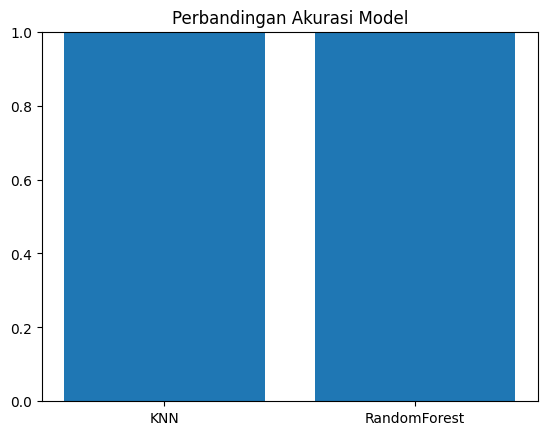

In [8]:
plt.bar(results.keys(), results.values())
plt.title("Perbandingan Akurasi Model")
plt.ylim(0, 1)
plt.show()